# Team Benchmark

**Authors:** Marissa Nicole Esteban, Gabe Krishnadasan, Diana Montoya-Herrera, Gabe Seidl, Madeleine Woo

**Date:** 10/5/2023

### Wave Height

#### Dataset: https://www.kaggle.com/code/shaltaf/the-prediction-of-significant-wave-height-hs/notebook 

## Table of Contents:
* [Data Importing and Pre-processing](#data-importing)
* [Data Analysis and Visualization](#data-vis)
* [Data Analytics](#data-analytics)

In [406]:
import sys

!{sys.executable} -m pip install seebuoy

In [407]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [408]:
from seebuoy import NDBC

ndbc = NDBC()

# Information on NDBC's ~1800 buoys and gliders
wave_df = ndbc.stations()

# list all available data for all buoys
df_data = ndbc.available_data()

# Get info on NY Harbor Buoy
station_id = "44065"
ny_buoy = ndbc.get_data(station_id)
ny_buoy


,wind_direction,wind_speed,wind_gust,wave_height,dominant_period,average_period,mean_wave_direction,pressure,air_temp,water_temp,dewpoint,visibility,pressure_tendency,tide
date,,,,,,,,,,,,,,
2024-01-01 00:00:00,NaN,6.0,8.0,NaN,NaN,NaN,NaN,1015.3,NaN,8.6,NaN,NaN,1.4,NaN
2024-01-01 00:10:00,NaN,6.0,8.0,0.6,NaN,4.2,190.0,1015.4,NaN,8.6,NaN,NaN,NaN,NaN
2024-01-01 00:20:00,NaN,7.0,8.0,0.6,8.0,4.2,190.0,1015.3,NaN,8.6,NaN,NaN,NaN,NaN
2024-01-01 00:30:00,NaN,7.0,8.0,NaN,NaN,NaN,NaN,1015.3,NaN,8.6,NaN,NaN,NaN,NaN
2024-01-01 00:40:00,NaN,6.0,8.0,NaN,NaN,NaN,NaN,1015.2,NaN,8.6,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-15 22:00:00,NaN,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,5.6,NaN,NaN,NaN,NaN
2024-02-15 22:10:00,NaN,9.0,11.0,0.7,NaN,3.3,188.0,NaN,NaN,5.6,NaN,NaN,NaN,NaN
2024-02-15 22:20:00,NaN,10.0,11.0,0.7,3.0,3.3,188.0,NaN,NaN,5.5,NaN,NaN,NaN,NaN


## Data Importing and Pre-processing <a class="anchor" id="data-importing"></a>

In [409]:
# import libraries needed
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm, skew, probplot
from scipy.special import boxcox1p
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 

In [410]:
# read in file
# wave_df = pd.read_csv('Coastal Data System - Waves (Mooloolaba) 01-2017 to 06 - 2019.csv')

In [411]:
# num rows and columns
ny_buoy.shape

(6519, 14)

In [412]:
# num of categorical variables
cat_count = 0
for dtype in ny_buoy.dtypes:
    if dtype == 'object':
        cat_count = cat_count + 1

In [413]:
print('# of categorical variables:',cat_count)
print('# of continuous variables:',ny_buoy.shape[1] - cat_count - 1) # subtract and extra column as 1 column is an ID column

# of categorical variables: 0
# of continuous variables: 13


In [414]:
# How I identified a buoy to investigate
ny_buoys = wave_df[wave_df['closest_state'] == 'New York']
ny_buoys.head()
# use 44065 because it's off the coast and not in a lake or something

,station_id,owner,ttype,hull,name,payload,location,timezone,forecast,note,lat_lon,lat,lon,closest_city,closest_state,ownercode,ownername,countrycode
321,44022,Y,Moored Buoy,NaN,Execution Rocks,NaN,"40.883 N 73.728 W (40&#176;53'0"" N 73&#176;43'...",E,FZUS51.KOKX,NaN,40.883 N 73.728 W,40.883,-73.728,New Rochelle,New York,Y,MYSOUND,US
324,44025,N,3-meter foam buoy,3D57,"LONG ISLAND - 30 NM South of Islip, NY",SCOOP payload,"40.251 N 73.164 W (40&#176;15'3"" N 73&#176;9'5...",E,FZNT21.KWBC FZUS51.KOKX,The buoy from station 44025 has gone adrift as...,40.251 N 73.164 W,40.251,-73.164,Freeport,New York,N,NDBC,US
357,44065,N,3-meter foam buoy,3DV12,New York Harbor Entrance - 15 NM SE of Breezy ...,SCOOP payload,"40.369 N 73.703 W (40&#176;22'10"" N 73&#176;42...",E,FZUS51.KOKX FZUS51.KPHI,Right whales are active off NY from November t...,40.369 N 73.703 W,40.369,-73.703,Valley Stream,New York,N,NDBC,US
358,44066,N,3-meter foam buoy,3DV46,"Texas Tower #4 - 75 NM East of Long Beach, NJ",SCOOP payload,"39.618 N 72.644 W (39&#176;37'6"" N 72&#176;38'...",E,FZNT22.KWBC,</p>Right whales are active off NJ from Novemb...,39.618 N 72.644 W,39.618,-72.644,Freeport,New York,N,NDBC,US
361,44069,ST,Buoy,NaN,Great South Bay,NaN,"40.699 N 73.087 W (40&#176;41'55"" N 73&#176;5'...",E,FZUS51.KOKX,Buoy recovered 2/4/24.,40.699 N 73.087 W,40.699,-73.087,Freeport,New York,ST,Stony Brook University,US


### Handling missing data

In [415]:

nan_count = ny_buoy.isna().sum()
nan_count

wind_direction         6519
wind_speed               16
wind_gust                16
wave_height            3223
dominant_period        4363
average_period         3223
mean_wave_direction    3223
pressure                342
air_temp               6519
water_temp               48
dewpoint               6519
visibility             6519
pressure_tendency      5515
tide                   6519
dtype: int64

In [416]:
# missing data
# it appears there is a lot of missing data
total_na = ny_buoy.isnull().sum().sort_values(ascending=False)

total_rows = ny_buoy.isnull().count()
percent = (ny_buoy.isnull().sum()/ny_buoy.isnull().count()).sort_values(ascending=False) * 100
missing_data = pd.concat([total_na, total_rows, percent], axis=1, keys=['Total NA', 'Total Rows', 'Percent'])
missing_data



,Total NA,Total Rows,Percent
wind_direction,6519,6519,100.000000
air_temp,6519,6519,100.000000
dewpoint,6519,6519,100.000000
visibility,6519,6519,100.000000
tide,6519,6519,100.000000
pressure_tendency,5515,6519,84.598865
dominant_period,4363,6519,66.927443
wave_height,3223,6519,49.440098
average_period,3223,6519,49.440098
mean_wave_direction,3223,6519,49.440098


In [417]:
# dropping cols where there is 100% NA
ny_buoy.dropna(axis=1, how='all', inplace=True)

# dropping rows where average_period is null
ny_buoy.dropna(subset=['average_period'], inplace=True)

# dropping rows wehre wave_height is null
ny_buoy.dropna(subset=['wave_height'], inplace=True)


In [418]:
# missing data after dropping cols
total_na = ny_buoy.isnull().sum().sort_values(ascending=False)

total_rows = ny_buoy.isnull().count()
percent = (ny_buoy.isnull().sum()/ny_buoy.isnull().count()).sort_values(ascending=False) * 100
missing_data = pd.concat([total_na, total_rows, percent], axis=1, keys=['Total NA', 'Total Rows', 'Percent'])
missing_data

,Total NA,Total Rows,Percent
pressure_tendency,3292,3296,99.878641
dominant_period,1140,3296,34.587379
pressure,179,3296,5.430825
water_temp,22,3296,0.667476
wind_speed,15,3296,0.455097
wind_gust,15,3296,0.455097
wave_height,0,3296,0.000000
average_period,0,3296,0.000000
mean_wave_direction,0,3296,0.000000


In [419]:
ny_buoy = ny_buoy.reset_index()
ny_buoy.columns

Index(['date', 'wind_speed', 'wind_gust', 'wave_height', 'dominant_period',
       'average_period', 'mean_wave_direction', 'pressure', 'water_temp',
       'pressure_tendency'],
      dtype='object')

In [420]:
ny_buoy['date']

0      2024-01-01 00:10:00
1      2024-01-01 00:20:00
2      2024-01-01 00:50:00
3      2024-01-01 01:10:00
4      2024-01-01 01:20:00
               ...        
3291   2024-02-15 21:10:00
3292   2024-02-15 21:20:00
3293   2024-02-15 21:50:00
3294   2024-02-15 22:10:00
3295   2024-02-15 22:20:00
Name: date, Length: 3296, dtype: datetime64[ns]

### Testing the validity of data acquisition

In [421]:
file_path = "C:\Users\maris\OneDrive\Documents\Benchmark\Benchmark-Code\44065.txt"
table_44065 = pd.read_csv(file_path, delim_whitespace=True)

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (1493046142.py, line 1)

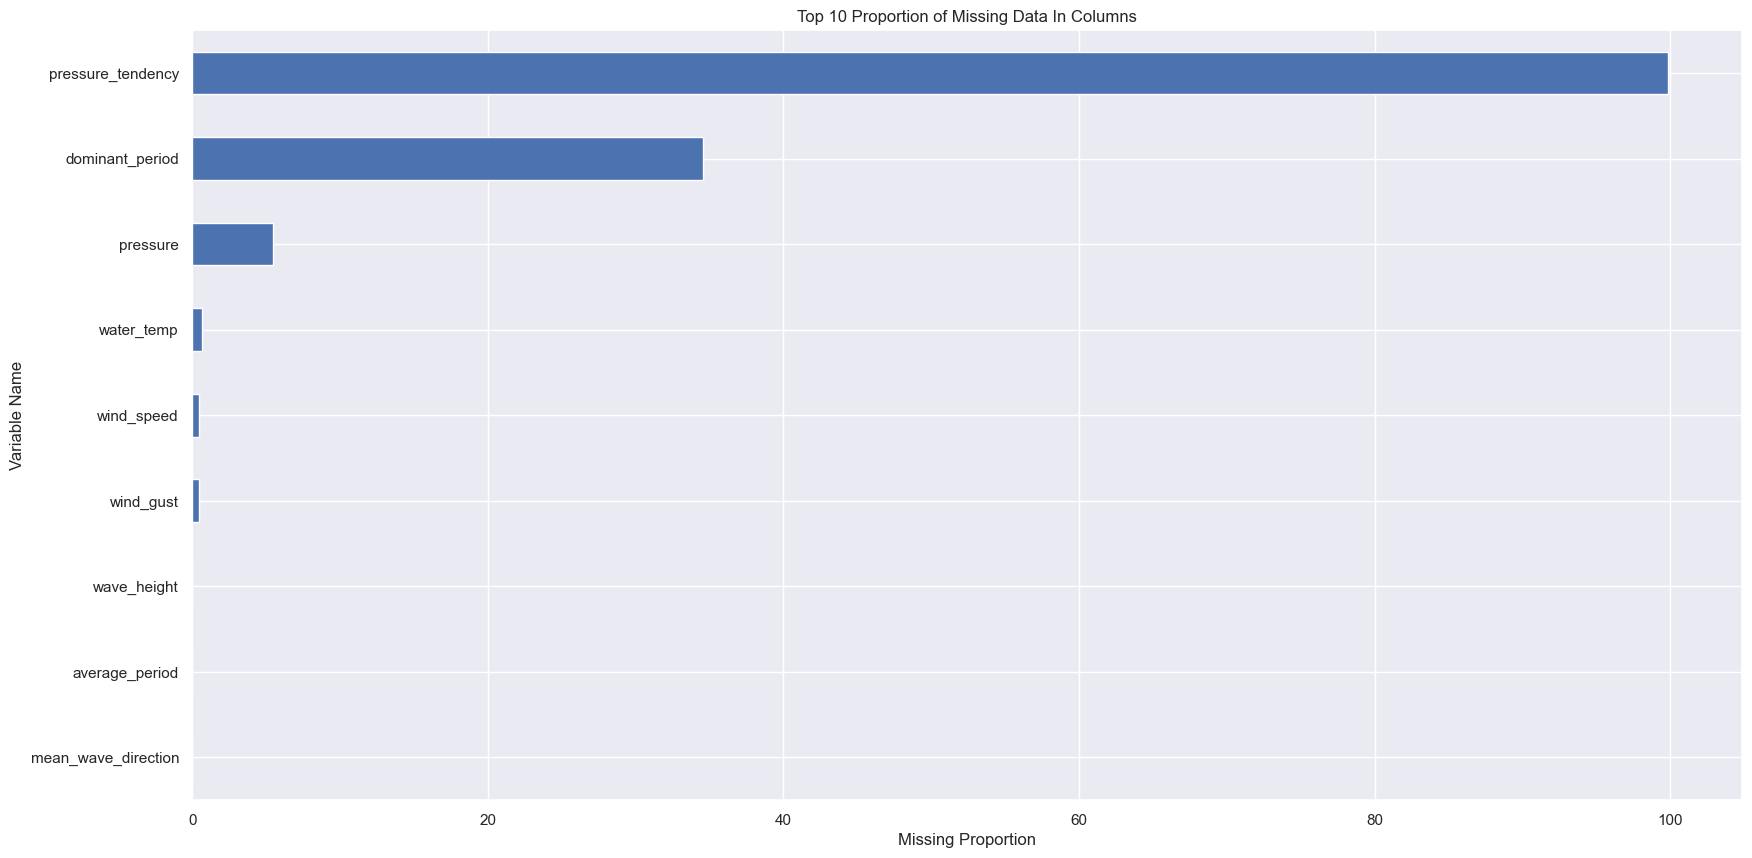

In [422]:
missing_data['Percent'].head(10).plot(kind='barh', figsize = (20,10)).invert_yaxis() # top 10 missing columns
plt.xlabel("Missing Proportion")
plt.ylabel("Variable Name")
plt.title("Top 10 Proportion of Missing Data In Columns")
plt.show()

## Handling missing data


In [423]:
ny_buoy.columns

Index(['date', 'wind_speed', 'wind_gust', 'wave_height', 'dominant_period',
       'average_period', 'mean_wave_direction', 'pressure', 'water_temp',
       'pressure_tendency'],
      dtype='object')

In [424]:
from sklearn.impute import SimpleImputer

# Replace missing data with mode
imputer = SimpleImputer(strategy='most_frequent')

# Interpolate for everything but the dates 
numeric_columns = ny_buoy.select_dtypes(include=['float64']).columns
imputer.fit(ny_buoy[numeric_columns])
ny_buoy_mode = pd.DataFrame(imputer.transform(ny_buoy[numeric_columns]), columns=ny_buoy[numeric_columns].columns)

# Replace missing data with mean
imputer = SimpleImputer(strategy='mean')
imputer.fit(ny_buoy[numeric_columns])
ny_buoy_mean = pd.DataFrame(imputer.transform(ny_buoy[numeric_columns]), columns=ny_buoy[numeric_columns].columns)

# Interpolate missing values using spline interpolation
ny_buoy_interpolated = ny_buoy[numeric_columns].interpolate(method='spline', order=2)

# Using imputed mode for the model (mean and interpolation will be tested later)
ny_buoy = pd.concat([ny_buoy[['date']], ny_buoy_mode], axis=1)



In [425]:
ny_buoy.columns

Index(['date', 'wind_speed', 'wind_gust', 'wave_height', 'dominant_period',
       'average_period', 'mean_wave_direction', 'pressure', 'water_temp',
       'pressure_tendency'],
      dtype='object')

In [426]:
#Check remaining missing values if any 
all_data_na = (ny_buoy.isnull().sum() / len(ny_buoy)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


In [427]:
ny_buoy.isnull().sum()

date                   0
wind_speed             0
wind_gust              0
wave_height            0
dominant_period        0
average_period         0
mean_wave_direction    0
pressure               0
water_temp             0
pressure_tendency      0
dtype: int64

### Handling Outliers

#### Target Variable

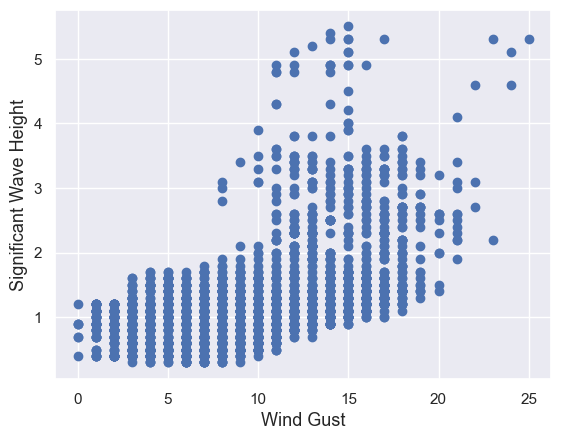

In [428]:
fig, ax = plt.subplots()
ax.scatter(x = ny_buoy['wind_gust'], y = ny_buoy['wave_height'])
plt.ylabel('Significant Wave Height', fontsize=13)
plt.xlabel('Wind Gust', fontsize=13)
plt.show()

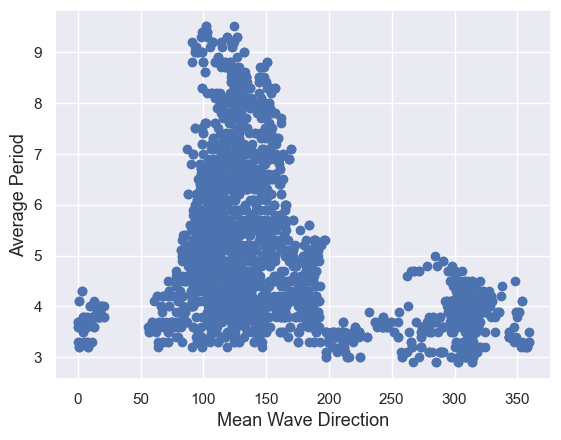

In [429]:
fig, ax = plt.subplots()
ax.scatter(x = ny_buoy['mean_wave_direction'], y = ny_buoy['average_period'],)
plt.ylabel('Average Period', fontsize=13)
plt.xlabel('Mean Wave Direction', fontsize=13)
plt.show()

In [430]:
# Remove non finite values
ny_buoy = ny_buoy[np.isfinite(ny_buoy['wave_height'])]


 mu = 0.75 and sigma = 0.27



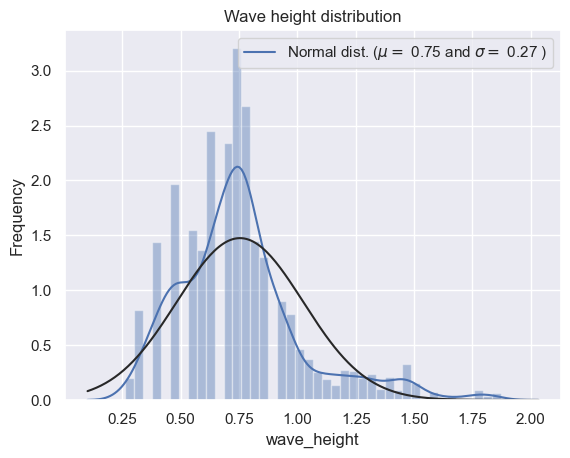

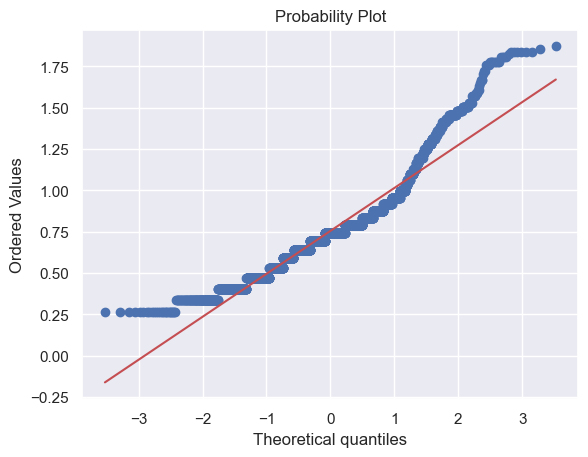

In [431]:
# We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
ny_buoy["wave_height"] = np.log1p(ny_buoy["wave_height"])

# Check the new distribution 
sns.distplot(ny_buoy['wave_height'] , fit=norm)

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(ny_buoy['wave_height'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Wave height distribution')

# Get also the QQ-plot
fig = plt.figure()
res = probplot(ny_buoy['wave_height'], plot=plt)
plt.show()


 mu = 1.79 and sigma = 0.22



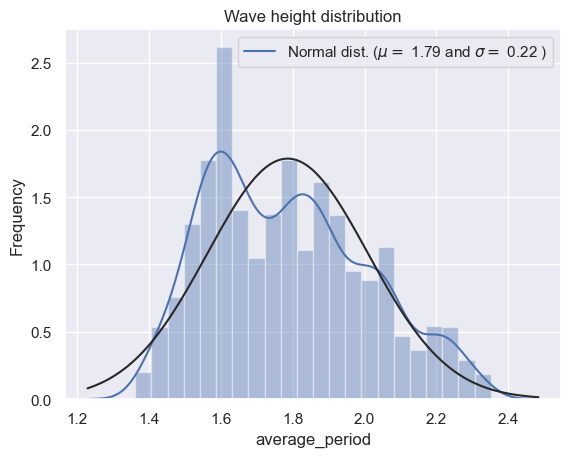

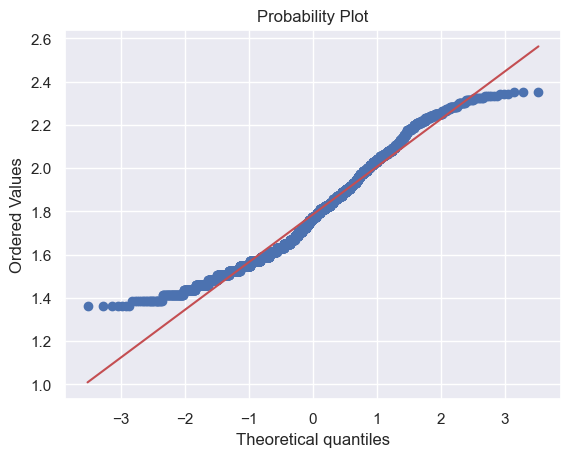

In [432]:
# We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
ny_buoy["average_period"] = np.log1p(ny_buoy["average_period"])

# Check the new distribution 
sns.distplot(ny_buoy['average_period'] , fit=norm)

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(ny_buoy['average_period'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Wave height distribution')

# Get also the QQ-plot
fig = plt.figure()
res = probplot(ny_buoy['average_period'], plot=plt)
plt.show()

## Data Analysis and Visualization <a class="anchor" id="data-vis"></a>

In [433]:
from sklearn.preprocessing import LabelEncoder

Target Variable Scatterplots

In [434]:
# scatterplot
sns.set()
cols = ['wind_direction', 'wind_speed', 'wind_gust', 'wave_height', 
        'dominant_period', 'average_period', 'mean_wave_direction', 
        'pressure', 'air_temp', 'water_temp', 'dewpoint', 'visibility',
        'pressure_tendency', 'tide']
sns.pairplot(ny_buoy[cols], size = 2.5)
plt.show();

KeyError: "['wind_direction', 'air_temp', 'dewpoint', 'visibility', 'tide'] not in index"

Correlation Matrix

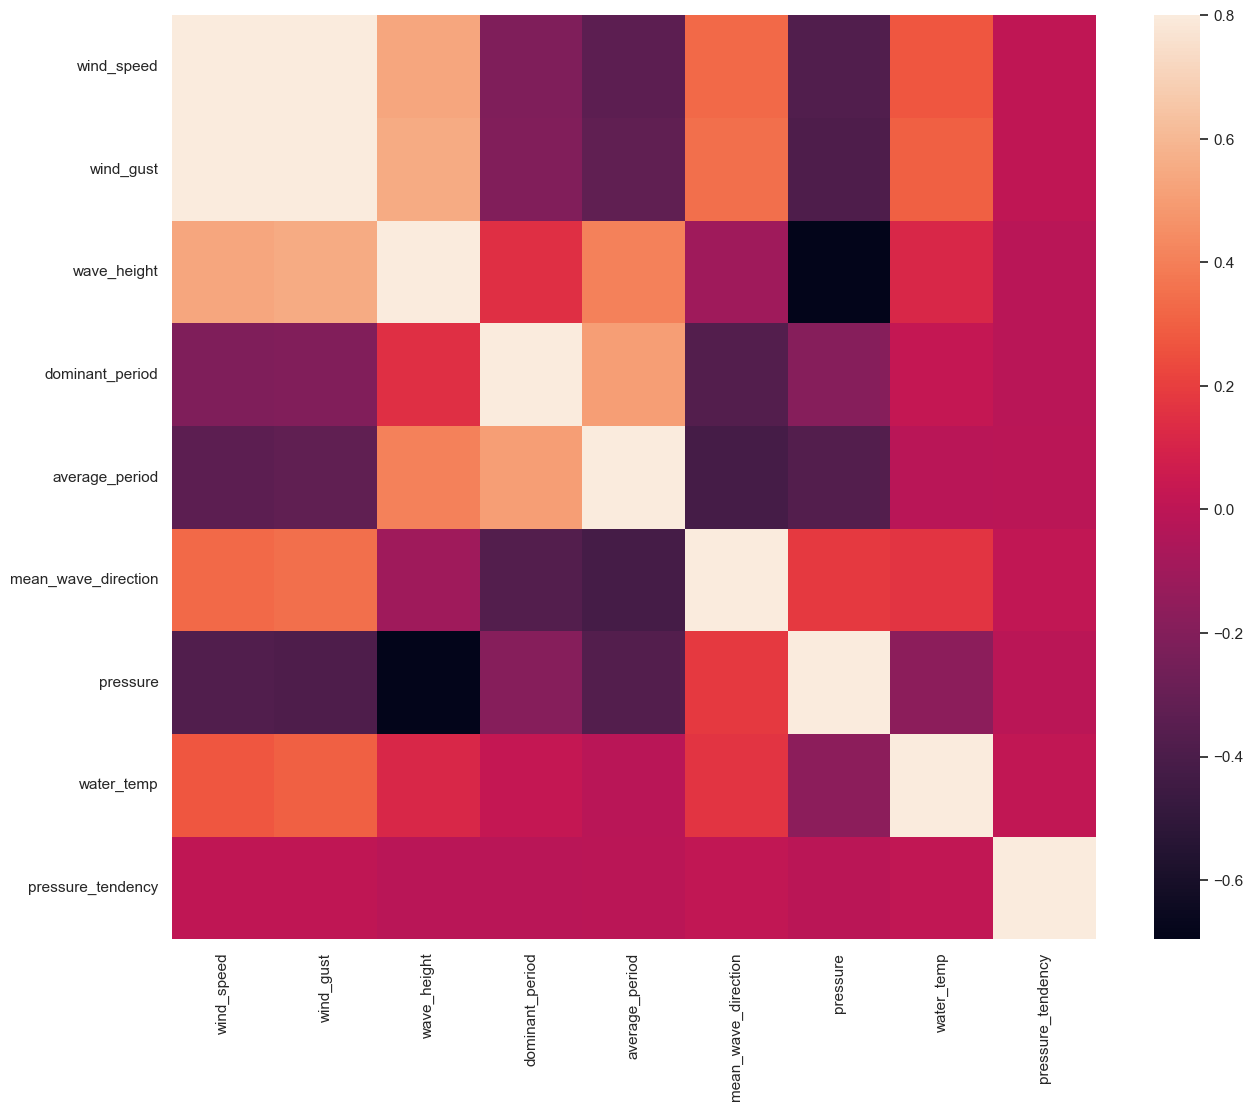

In [435]:
# Correlation map to see how conditions are correlated with wave height and average period
corrmat = ny_buoy.corr()
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(corrmat, vmax=.8, square=True);

In [436]:
# TODO: Here, we would change continuous variables to categorical variables if needed.
# For this example, we don't need to do this.

#### Label encode categorical variables

In [437]:
# We only have one categorical variable, so we won't be doing this step at this point

## Data Analytics <a class="anchor" id="data-analytics"></a>

Added below to run code on codespaces that dont have things pre installed

In [438]:
import sys

!{sys.executable} -m pip install xgboost
!{sys.executable} -m pip install lightgbm

In [439]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
#import xgboost as xgb
#import lightgbm as lgb

In [440]:
print(ny_buoy.columns)

Index(['date', 'wind_speed', 'wind_gust', 'wave_height', 'dominant_period',
       'average_period', 'mean_wave_direction', 'pressure', 'water_temp',
       'pressure_tendency'],
      dtype='object')


In [441]:
ny_buoy['date'] = pd.to_datetime(ny_buoy['date'])

In [442]:
def time_series_split_regression(
    data,
    regressor,
    date_column="date",
    target_column="wave_height",
    cols_to_ignore=[],
    n_splits=5,
):
    """
    Perform time series split on a pandas DataFrame based on a date column and
    train a regression model, calculating RMSE for each split.

    Parameters:
    - data: pandas DataFrame
    - regressor: scikit-learn regressor object
        The regression algorithm to use.
    - date_column: str, default="date"
        The name of the date column in the DataFrame.
    - target_column: str, default="wave_height"
        The name of the target column in the DataFrame.
    - n_splits: int, default=5
        Number of splits for TimeSeriesSplit.
    - tune_hyperparameters: bool, default=False

    Returns:
    - result_df: pandas DataFrame
        DataFrame containing the Id, actual value, predicted value, fold, and whether it was in the test or train set.
    - rmse_scores: list of floats
        List of RMSE scores for each split.
    - split_dates: list of tuples
        List of (min_date, max_date) tuples for each split.
    - num_records: list of tuples
        List of (train_size, test_size) tuples for each split.
    """

    # Sort the DataFrame based on the date column
    data = data.sort_values(by=date_column)

    # Initialize TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)

    rmse_scores = []
    split_dates = []
    num_records = []
    all_predictions = []

    # Perform the time series split and train regression model for each split
    for fold, (train_index, test_index) in enumerate(tscv.split(data)):
        train_data, test_data = data.iloc[train_index], data.iloc[test_index]

        cols_to_ignore = cols_to_ignore + [target_column, date_column]

        X_train = train_data.drop(cols_to_ignore, axis=1)
        X_test = test_data.drop(cols_to_ignore, axis=1)
        y_train, y_test = train_data[target_column], test_data[target_column]

        # Record the minimum and maximum dates for each split
        min_date, max_date = test_data[date_column].min(), test_data[date_column].max()
        split_dates.append((min_date, max_date))

        # Train regression model
        regressor.fit(
            X_train, np.log1p(y_train)
        )  # Apply log1p transformation to the target variable during training

        # Make predictions
        y_pred_log = regressor.predict(X_test)
        y_pred_train_log = regressor.predict(X_train)

        # Inverse transform predictions to get back the original scale
        # TODO: does this apply to our data too? Still kind of confused on what this does.
        y_pred = np.expm1(y_pred_log)
        y_pred_train = np.expm1(y_pred_train_log)

        # Check for NaN or infinity values in y_pred or y_test
        if (
            np.isnan(y_pred).any()
            or np.isinf(y_pred).any()
            or np.isnan(y_test).any()
            or np.isinf(y_test).any()
        ):
            print(
                f"Warning: NaN or infinity values found in predictions or true values. Imputing 0 for problematic values in y_pred for fold {fold}."
            )
            y_pred[np.isnan(y_pred) | np.isinf(y_pred)] = 0
            # Optionally, you can also handle y_test in a similar way if needed
            # y_test[np.isnan(y_test) | np.isinf(y_test)] = 0

        # Calculate RMSE on the original scale
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        rmse_scores.append((rmse, fold))

        # Record results for 'date', 'Actual', 'Predicted', 'Fold', and 'Set' in a list
        # TODO: what it doooooo?????
        fold_predictions = list(
            zip(
                test_data["date"],
                y_test,
                y_pred,
                [fold] * len(test_data),
                ["test"] * len(test_data),
            )
        )
        fold_predictions += list(
            zip(
                train_data["date"],
                y_train,
                y_pred_train,
                [fold] * len(train_data),
                ["train"] * len(train_data),
            )
        )
        all_predictions.extend(fold_predictions)

        # Calculate the size of each train-test split
        num_records.append((len(train_data), len(test_data)))

    # Create a DataFrame from the results
    result_df = pd.DataFrame(
        all_predictions, columns=["date", "Actual", "Predicted", "Fold", "Set"]
    )

    return result_df, rmse_scores, split_dates, num_records


# Example usage:
# result_df, rmse_scores, split_dates, num_records = time_series_split_regression(data, 'date_column', 'target_column', regressor)

In [443]:
def compute_rmse_std(tuple_list):
    first_elements = [t[0] for t in tuple_list]
    mean = np.mean(first_elements)
    std = np.std(first_elements)
    return mean, std

    return average # TODO: why this here????


def print_rmse_and_dates(model_rmse, model_split_dates, num_records, model_name):
    # Print RMSE scores and split dates for each split
    for i, (rmse, dates, records) in enumerate(
        zip(model_rmse, model_split_dates, num_records)
    ):
        min_date, max_date = dates
        num_train_records, num_test_records = records

        min_date = min_date.date()
        max_date = max_date.date()

        print(
            f"Split {i + 1}: Min Date: {min_date}, Max Date: {max_date}, RMSE: {rmse[0]}, Train Records: {num_train_records}, Test Records: {num_test_records}"
        )

    rmse_std = compute_rmse_std(model_rmse)
    print(model_name, "RMSE score: {:.4f} ({:.4f})\n".format(rmse_std[0], rmse_std[1]))

In [444]:
# return a list containing all the column names in wave_df except for 'Hs'.
# aka isolating our dependent variable: avg wave height. 
# train_df = ny_buoy[ny_buoy.columns.difference(['wave_height', 'average_period'])]
# train_df.head()

In [445]:
# Linear regression models
# 3 types here: with intercept, without intercept, and Elastic Net (both L1 and L2 regularization)
lr_w_int = LinearRegression()
lr_no_int = LinearRegression(fit_intercept=False)
elastic_net = ElasticNet(
    alpha=0.01, l1_ratio=0.1
)  # Adjust alpha and l1_ratio as needed

In [446]:
lr_w_int = LinearRegression()
lr_no_int = LinearRegression(fit_intercept=False)

In [447]:
neigh = KNeighborsRegressor(n_neighbors=10)

In [448]:
rf = RandomForestRegressor(n_estimators=100)

In [449]:
dt = DecisionTreeRegressor(max_depth = 10)

In [450]:
# model_xgb = xgb.XGBRegressor(max_depth=5, n_estimators=1000, learning_rate=0.01)

In [451]:
# model_lgb = lgb.LGBMRegressor(learning_rate=0.01, max_depth=5, n_estimators=1000)

#### Algorithm Results on a 5 Fold Cross Validation

In [452]:
(
    lr_w_int_preds_df,
    lr_w_int_rmse,
    lr_w_int_split_dates,
    num_records,
) = time_series_split_regression(
    ny_buoy,
    regressor=lr_w_int,
)

# Print RMSE scores and split dates for each split
print_rmse_and_dates(
    lr_w_int_rmse, lr_w_int_split_dates, num_records, "Linear Regression (w/ Intercept)"
)

Split 1: Min Date: 2024-01-08, Max Date: 2024-01-16, RMSE: 0.1964412537089984, Train Records: 551, Test Records: 549
Split 2: Min Date: 2024-01-16, Max Date: 2024-01-23, RMSE: 0.15386536808283344, Train Records: 1100, Test Records: 549
Split 3: Min Date: 2024-01-23, Max Date: 2024-01-31, RMSE: 0.1701040241270888, Train Records: 1649, Test Records: 549
Split 4: Min Date: 2024-01-31, Max Date: 2024-02-08, RMSE: 0.1280326733210046, Train Records: 2198, Test Records: 549
Split 5: Min Date: 2024-02-08, Max Date: 2024-02-15, RMSE: 0.16147376442259007, Train Records: 2747, Test Records: 549
Linear Regression (w/ Intercept) RMSE score: 0.1620 (0.0222)



In [ ]:
# score_linear = rmse_cv(lr_w_int,n_folds)
# print("Linear Regression (w/ Intercept) score: {:.4f} ({:.4f})\n".format(score_linear.mean(), score_linear.std()))

In [ ]:
# score_linear_no_int = rmse_cv(lr_no_int,n_folds)
# print("Linear Regression (No Intercept) score: {:.4f} ({:.4f})\n".format(score_linear_no_int.mean(), score_linear_no_int.std()))

In [ ]:
# score_neigh = rmse_cv(neigh,n_folds)
# print("Nearest Neighbor (13) score: {:.4f} ({:.4f})\n".format(score_neigh.mean(), score_neigh.std()))

In [ ]:
# score_dt = rmse_cv(dt,n_folds)
# print("Decision Tree Regression score: {:.4f} ({:.4f})\n".format(score_dt.mean(), score_dt.std()))

In [453]:
rf_preds_df, rf_rmse, rf_split_dates, num_records = time_series_split_regression(
    ny_buoy,
    regressor=rf,
)
print_rmse_and_dates(rf_rmse, rf_split_dates, num_records, "Random Forest")

Split 1: Min Date: 2024-01-08, Max Date: 2024-01-16, RMSE: 0.20098310402032066, Train Records: 551, Test Records: 549
Split 2: Min Date: 2024-01-16, Max Date: 2024-01-23, RMSE: 0.12473912784883616, Train Records: 1100, Test Records: 549
Split 3: Min Date: 2024-01-23, Max Date: 2024-01-31, RMSE: 0.1380740095447077, Train Records: 1649, Test Records: 549
Split 4: Min Date: 2024-01-31, Max Date: 2024-02-08, RMSE: 0.14297658384970907, Train Records: 2198, Test Records: 549
Split 5: Min Date: 2024-02-08, Max Date: 2024-02-15, RMSE: 0.11588060849033506, Train Records: 2747, Test Records: 549
Random Forest RMSE score: 0.1445 (0.0298)



In [ ]:
# score_xg = rmse_cv(model_xgb,n_folds)
# print("Xgboost score: {:.4f} ({:.4f})\n".format(score_xg.mean(), score_xg.std()))

Xgboost score: 0.1243 (0.0492)



In [ ]:
# score_lgbm = rmse_cv(model_lgb,n_folds)
# print("LGBM score: {:.4f} ({:.4f})\n" .format(score_lgbm.mean(), score_lgbm.std()))

LGBM score: 0.1245 (0.0510)



In [ ]:
# # plot RMSE and STD for each Algorithm
# data = {'Linear (No Intercept)':[score_linear_no_int.mean(),score_linear_no_int.std()], 'XGBoost':[score_xg.mean(),score_xg.std()], 'Random Forest': [score_rf.mean(),score_rf.std()]
#         , 'LightGBM': [score_lgbm.mean(),score_lgbm.std()], 'Decision Tree': [score_dt.mean(),score_dt.std()],'Nearest Neighbor': [score_neigh.mean(),score_neigh.std()]}
# data_df = pd.DataFrame(data=data).T.reset_index().sort_values(by = [0],ascending = True)
# data_df.columns = ['Algorithm','RMSE','STD']

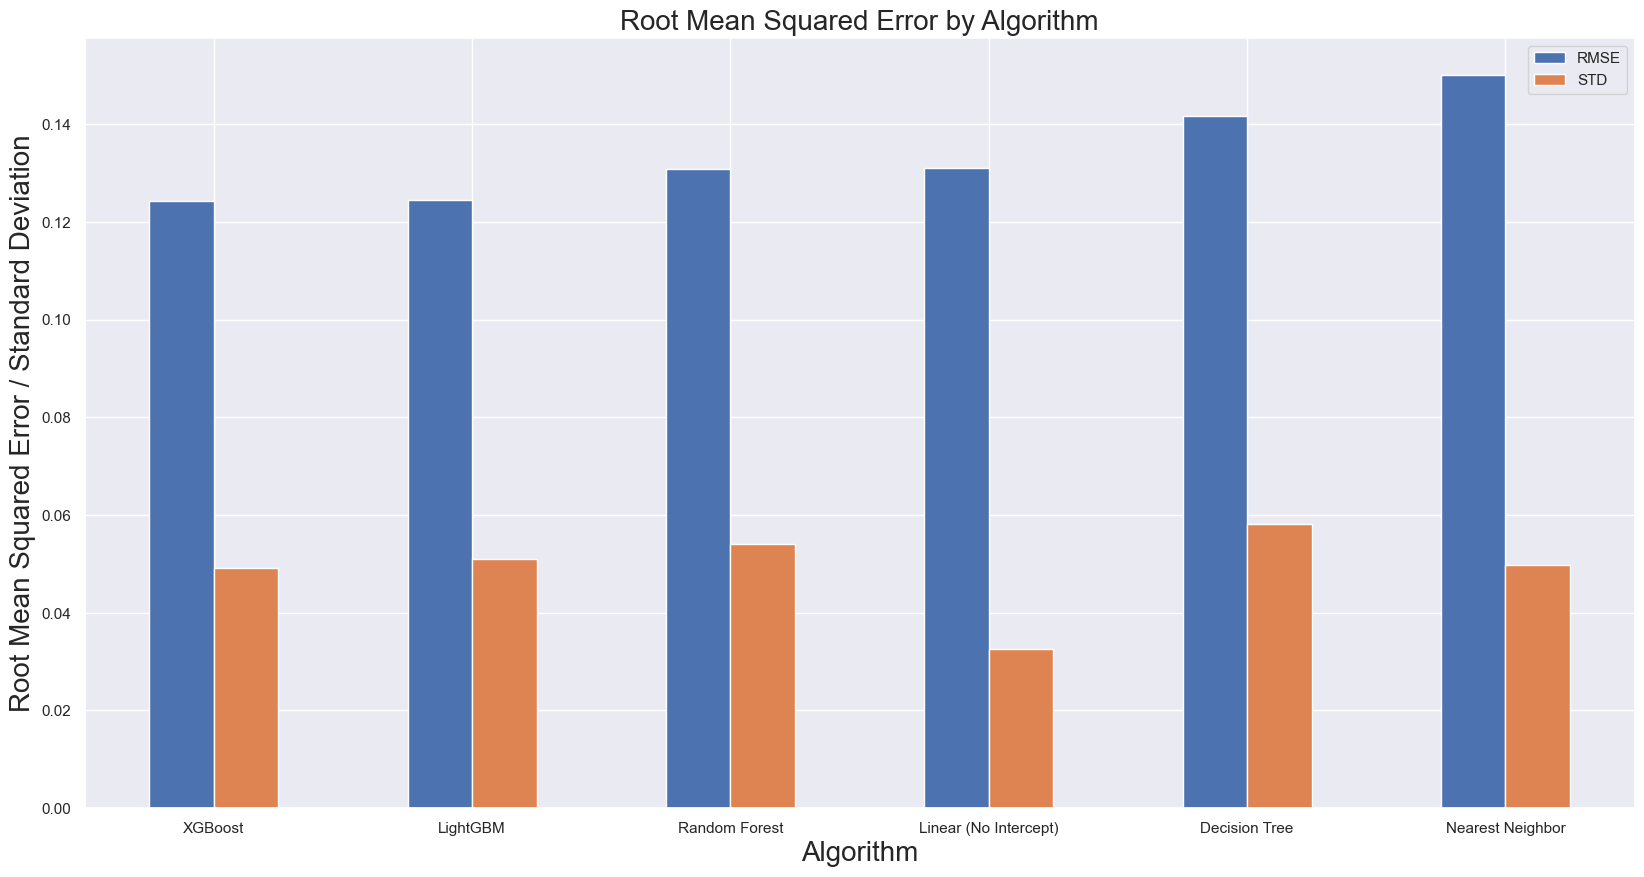

In [ ]:
# # creating the bar plot
# data_df.plot(kind='bar',x = 'Algorithm', y = ['RMSE', 'STD'], figsize = (20,10), rot=0)
# plt.xlabel("Algorithm",fontsize=20)
# plt.ylabel("Root Mean Squared Error / Standard Deviation",fontsize=20)
# plt.title("Root Mean Squared Error by Algorithm",fontsize=20)
# plt.show()

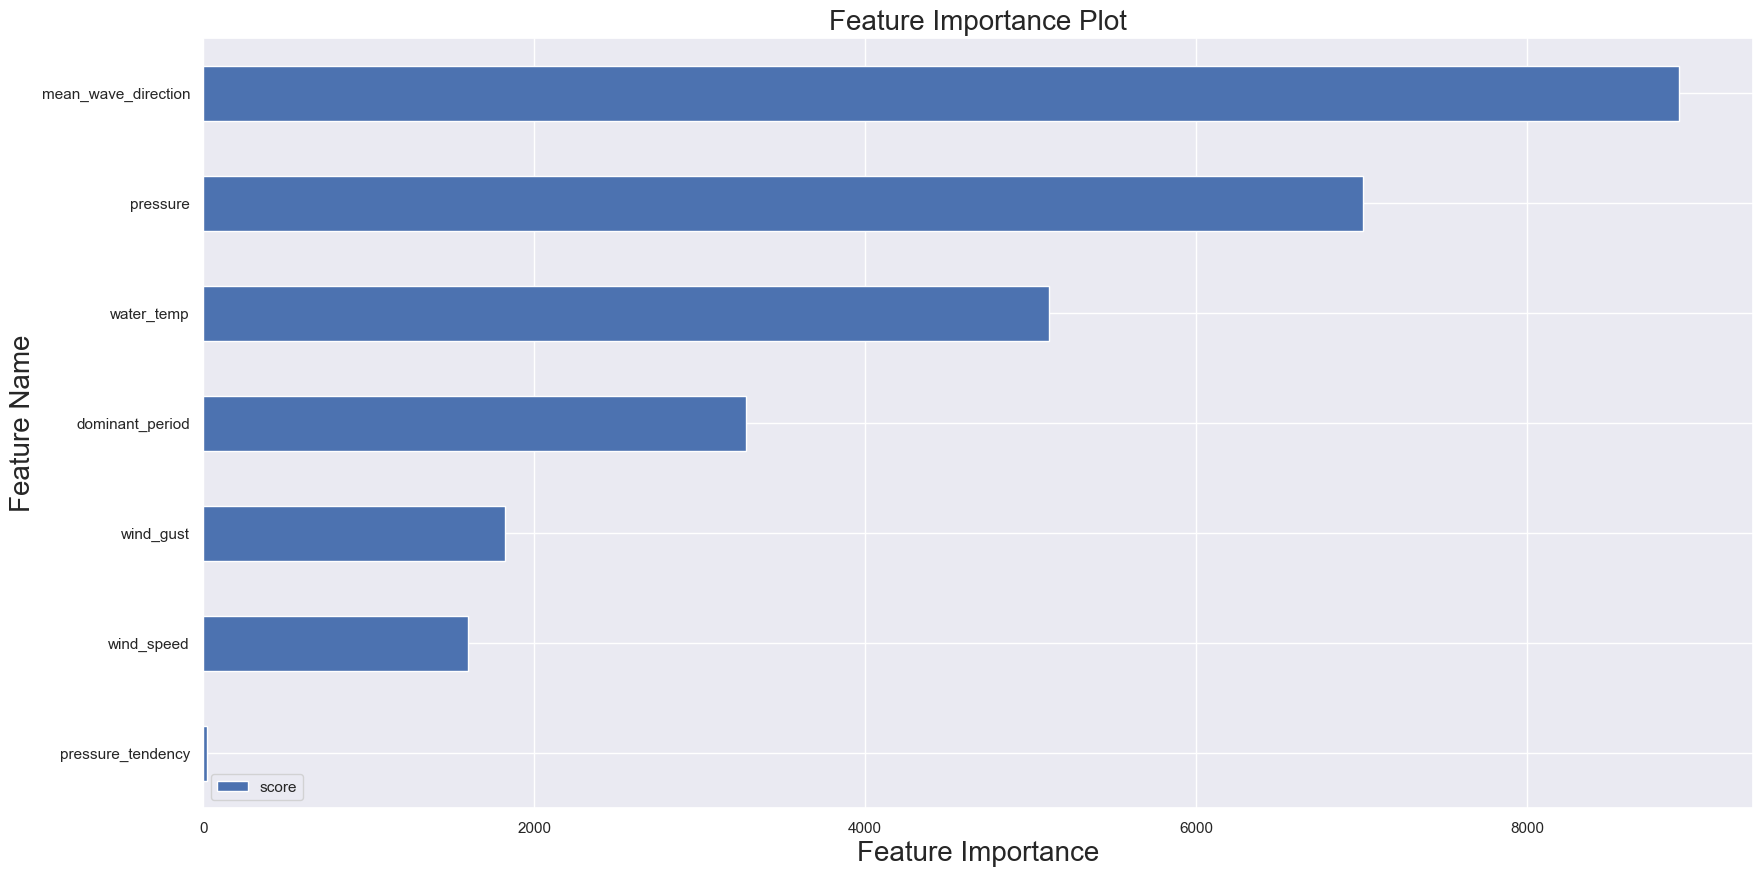

In [ ]:
# model = model_xgb.fit(train_df, ny_buoy.wave_height) #fit model on entire dataset to get variable importance since we fit it on each fold
# feature_important = model.get_booster().get_score(importance_type='weight')

# keys = list(feature_important.keys())
# values = list(feature_important.values())

# data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
# data[:20].plot(kind='barh', figsize = (20,10)).invert_yaxis(); ## plot top 20 features
# plt.xlabel("Feature Importance",fontsize=20)
# plt.ylabel("Feature Name",fontsize=20)
# plt.title("Feature Importance Plot",fontsize=20)
# plt.show()

## Repeat Training Models, but for Average Period

In [ ]:
# Validation function for wave height
n_folds = 5

def rmse_cv_period(model,n_folds):
    kf=KFold(n_splits=n_folds)
    rmse_period = np.sqrt(-cross_val_score(model, train_df, ny_buoy.average_period, scoring="neg_mean_squared_error", cv = kf))
    return rmse_period

In [ ]:
score_linear = rmse_cv_period(lr_w_int,n_folds)
print("Linear Regression (w/ Intercept) score: {:.4f} ({:.4f})\n".format(score_linear.mean(), score_linear.std()))

Linear Regression (w/ Intercept) score: 0.1451 (0.0302)



In [ ]:
score_linear_no_int = rmse_cv_period(lr_no_int,n_folds)
print("Linear Regression (No Intercept) score: {:.4f} ({:.4f})\n".format(score_linear_no_int.mean(), score_linear_no_int.std()))

Linear Regression (No Intercept) score: 0.1441 (0.0263)



In [ ]:
score_neigh = rmse_cv_period(neigh,n_folds)
print("Nearest Neighbor (13) score: {:.4f} ({:.4f})\n".format(score_neigh.mean(), score_neigh.std()))

Nearest Neighbor (13) score: 0.1296 (0.0238)



In [ ]:
score_dt = rmse_cv_period(dt,n_folds)
print("Decision Tree Regression score: {:.4f} ({:.4f})\n".format(score_dt.mean(), score_dt.std()))

Decision Tree Regression score: 0.1338 (0.0201)



In [ ]:
score_rf = rmse_cv_period(rf,n_folds)
print("Random Forest Regression score: {:.4f} ({:.4f})\n".format(score_rf.mean(), score_rf.std()))

NameError: name 'rmse_cv_period' is not defined

In [ ]:
score_xg = rmse_cv_period(model_xgb,n_folds)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score_xg.mean(), score_xg.std()))

Xgboost score: 0.1045 (0.0105)



In [ ]:
score_lgbm = rmse_cv_period(model_lgb,n_folds)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score_lgbm.mean(), score_lgbm.std()))

LGBM score: 0.1035 (0.0093)



In [ ]:
# plot RMSE and STD for each Algorithm
data = {'Linear (No Intercept)':[score_linear_no_int.mean(),score_linear_no_int.std()], 'XGBoost':[score_xg.mean(),score_xg.std()], 'Random Forest': [score_rf.mean(),score_rf.std()]
        , 'LightGBM': [score_lgbm.mean(),score_lgbm.std()], 'Decision Tree': [score_dt.mean(),score_dt.std()],'Nearest Neighbor': [score_neigh.mean(),score_neigh.std()]}
data_df = pd.DataFrame(data=data).T.reset_index().sort_values(by = [0],ascending = True)
data_df.columns = ['Algorithm','RMSE','STD']

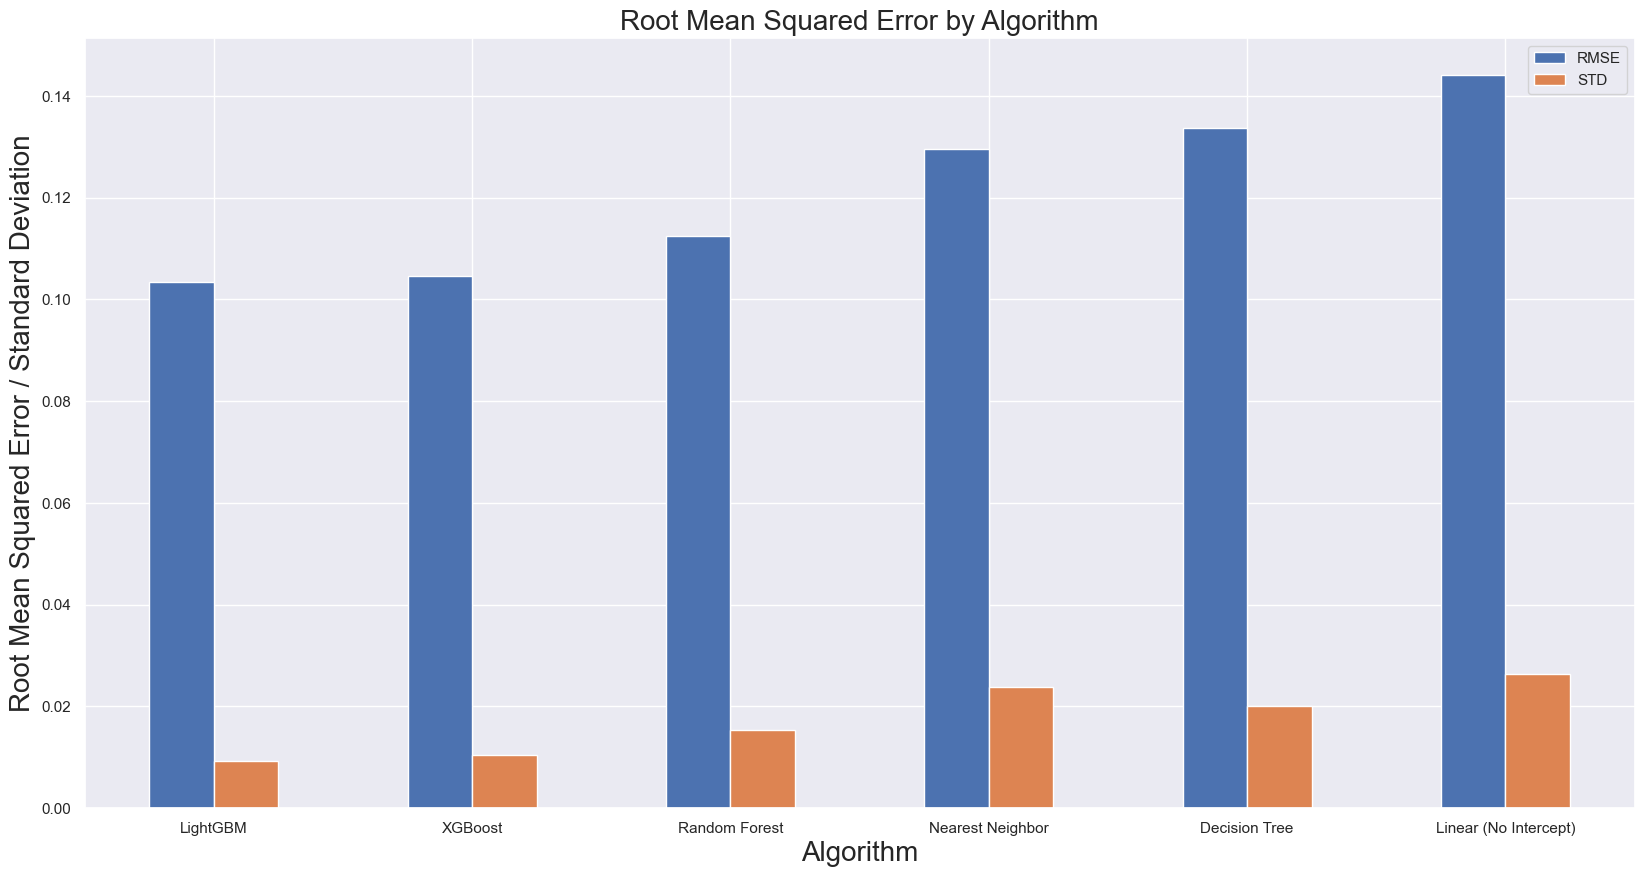

In [ ]:
# creating the bar plot
data_df.plot(kind='bar',x = 'Algorithm', y = ['RMSE', 'STD'], figsize = (20,10), rot=0)
plt.xlabel("Algorithm",fontsize=20)
plt.ylabel("Root Mean Squared Error / Standard Deviation",fontsize=20)
plt.title("Root Mean Squared Error by Algorithm",fontsize=20)
plt.show()

<AxesSubplot:title={'center':'LightGBM Feature Importance (Gain)'}, xlabel='Feature importance', ylabel='Features'>

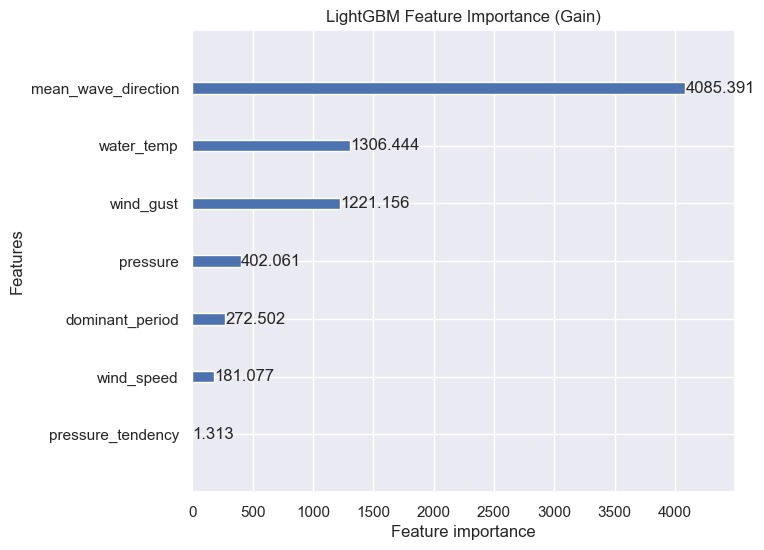

In [ ]:
model = model_lgb.fit(train_df, ny_buoy.average_period) #fit model on entire dataset to get variable importance since we fit it on each fold
lgb.plot_importance(model, importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance (Gain)")

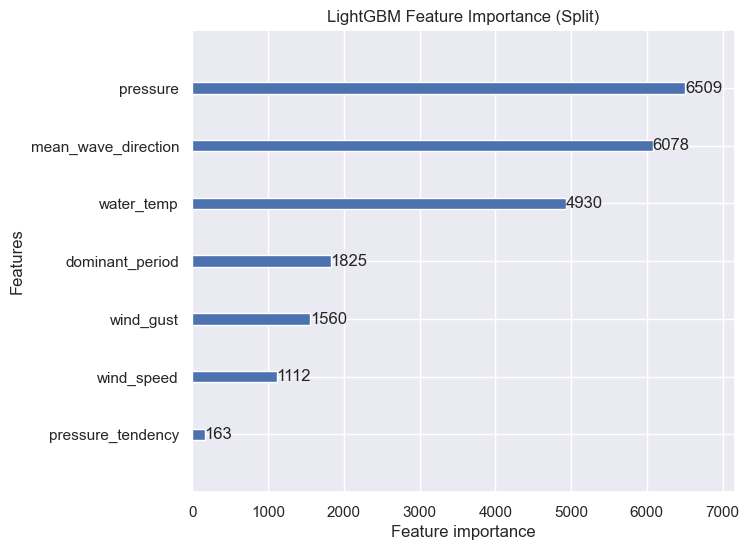

In [ ]:
# Plot feature importance using Split
lgb.plot_importance(model, importance_type="split", figsize=(7,6), title="LightGBM Feature Importance (Split)")
plt.show()